In [21]:
import smart_open
dir(smart_open)

['_WARNED',
 '_WARNING',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'azure',
 'bytebuffer',
 'compression',
 'concurrency',
 'constants',
 'doctools',
 'gcs',
 'hdfs',
 'http',
 'local_file',
 'logger',
 'logging',
 'open',
 'parse_uri',
 'register_compressor',
 's3',
 's3_iter_bucket',
 'smart_open',
 'smart_open_lib',
 'ssh',
 'transport',
 'utils',
 'version',
 'webhdfs']

In [22]:
#import modules
import os.path
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import bigrams
from gensim import corpora
from gensim.models import LsiModel
import matplotlib.pyplot as plt

import numpy as np
import itertools
import pandas as pd
 
from numpy import linalg as la

In [23]:
# this was the original function I copied from some tutorial. It computes word coocurrence in 
# "bigrams" but I overwrite it below to compute coocurrence in 15-grams, similar to the 
# Huth paper.
def generate_co_occurrence_matrix(corpus):
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word,
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    co_occurrence_matrix = np.matrix(co_occurrence_matrix)
 
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

In [24]:
# this reproduces the 15-gram, log transformed zscore coocurrence matrices of Huth et. al
def generate_co_occurrence_matrix(corpus):
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create 15-grams from all words in corpus
    n_grams = list(nltk.everygrams(corpus,min_len=15,max_len=15)) 
    
    m = np.zeros([len(vocab),len(n_grams)]);
    for i,word1 in enumerate(vocab):
        for j,this_n_gram in enumerate(n_grams):
            if word1 in this_n_gram:
                 m[i,j]=1

    co_occurrence_matrix = np.matrix(m)*np.matrix(np.transpose(m))

    wordFreq = np.sum(m,axis=1)
    frqtSrt = np.argsort(wordFreq)
    frqtSrt = frqtSrt[::-1]
    most_common = frqtSrt[0:985]
    
    co_occurrence_matrix = co_occurrence_matrix.take(most_common,axis=1)
    
    # normalize incidence
    #incidence = np.sum(m,axis=1)
    #a,b = np.shape(m)
    #from numpy import matlib as ml
    #incidence = ml.repmat(incidence,n=1,m=a)
    #co_occurrence_matrix = co_occurrence_matrix/(incidence*np.transpose(incidence))
    co_occurrence_matrix = np.log(1 + co_occurrence_matrix)
    from scipy import stats as sts
    co_occurrence_matrix = sts.zscore(sts.zscore(np.array(co_occurrence_matrix),axis=0),axis=1)

    vocab_tuple = tuple(vocab_index)
    basis_index = [];
    for i in range(0,len(most_common)):
        basis_index.append(vocab_tuple[most_common[i]])
    
    return co_occurrence_matrix, vocab_index, basis_index
#plt.matshow(m)
#idx = list(range(0,len(vocab),10))
#plt.gca().set_xticks(idx)
#plt.gca().set_xticklabels([vocab[i] for i in idx],rotation=90)
#plt.gca().set_yticks(idx)
#plt.gca().set_yticklabels([vocab[i] for i in idx]

In [25]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [26]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [27]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [28]:
# LSA Model
#number_of_topics=7
#words=10
document_list,titles=load_data("","articles.csv")
clean_text=preprocess_data(document_list)

Total Number of Documents: 4551


In [33]:
data = list(itertools.chain.from_iterable(clean_text))
matrix, vocab_index, basis_index = generate_co_occurrence_matrix(data[1:20000])

In [34]:
# get highest frequency words (they look better when plotted)
idx = []
for i in range(0,len(matrix)):
    m = np.mean(np.abs(matrix[i]))
    if m > np.power(float(10),-0.05):
        idx.append(i) 

# I picked an arbitrary threshold above, so let's see how many words it picks.
len(idx)

34

In [35]:
vocab_tuple = tuple(vocab_index)
subvocab = [];
for i in range(0,len(idx)):
    subvocab.append(vocab_tuple[idx[i]])

[Text(0, 0, 'dexeu'),
 Text(0, 500, 'stutter'),
 Text(0, 1000, '3am'),
 Text(0, 1500, 'collat'),
 Text(0, 2000, 'charact'),
 Text(0, 2500, 'graduat'),
 Text(0, 3000, 'colleagu'),
 Text(0, 3500, 'weather'),
 Text(0, 4000, 'tight'),
 Text(0, 4500, 'punt')]

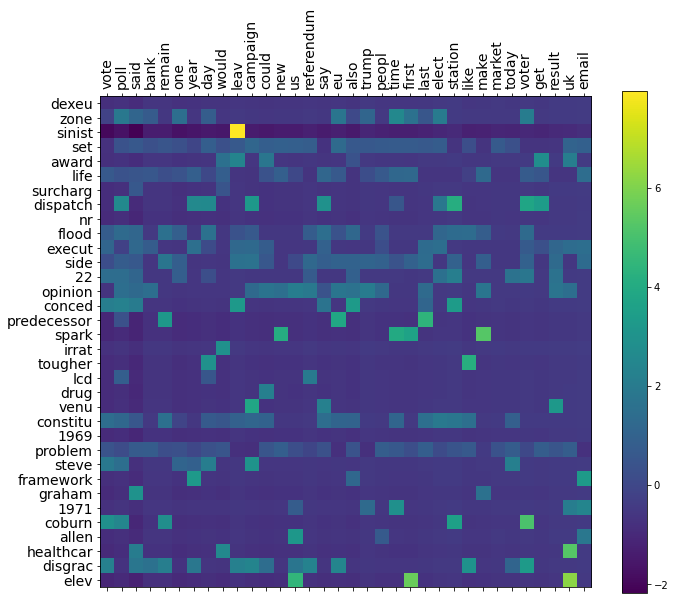

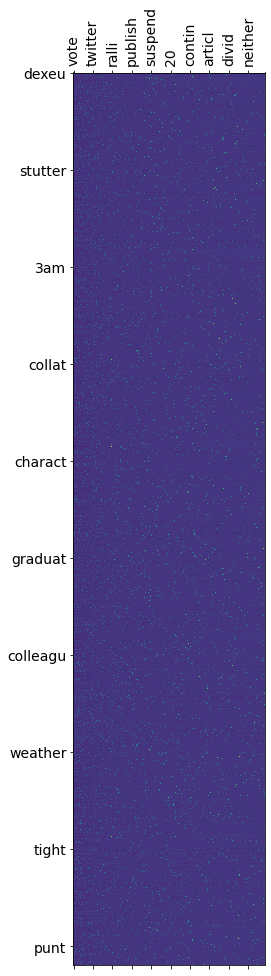

In [36]:
p = plt.matshow(matrix.take(list(range(0,len(idx))),axis=0).take(list(range(0,len(idx))),axis=1))

plt.gca().set_xticks(range(0,len(idx)))
plt.gca().set_xticklabels(list(basis_index[0:len(idx)]), rotation=90, fontsize=14)

plt.gca().set_yticks(range(0,len(idx)))
plt.gca().set_yticklabels(list(vocab_tuple[0:len(idx)]), fontsize=14)
f = plt.gcf()
f.colorbar(plt.gci())
f.set_size_inches(11,9)

p = plt.matshow(matrix)
plt.gca().set_xticks(range(0,len(basis_index),100))
plt.gca().set_xticklabels(list(basis_index[0:len(basis_index):100]), rotation=90, fontsize=14)

plt.gca().set_yticks(range(0,len(vocab_tuple),500))
plt.gca().set_yticklabels(list(vocab_tuple[0:len(vocab_tuple):500]), fontsize=14)